In [1]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import RFE, RFECV, f_regression, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import  KNeighborsClassifier
from datetime import datetime as dt
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from imblearn.combine import SMOTETomek
from collections import Counter
from mlxtend.feature_selection import ColumnSelector
import warnings
# Settings the warnings to be ignored
warnings.filterwarnings('ignore')

In [2]:
# Displaying all columns
pd.set_option('display.max_columns', None)

#Display all data in columns
pd.set_option("display.max_colwidth", None)

np.set_printoptions(threshold=None, edgeitems=None, linewidth=None, suppress=None)
pd.set_option("display.max_rows", None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)


In [3]:
#Storing Accuracy

data_accuracy = pd.DataFrame(columns=['Algo', 'Accuracy(KFold)', 'Test', 'Train', 'Recall', 'Precision', 'F1', 'ROC_AUC_SCORE'])
def store(data):
    data_accuracy.loc[len(data_accuracy.index)] = data
    data_accuracy.to_csv('loan_prediction_metric_scores.csv')
    # print(data_accuracy)



def get_info_pipeline(pipe_name):
    sub_pipe = pipe_name[:-1]
    transformed_df = pd.DataFrame(
        data=sub_pipe.fit_transform(X_train, y_train),
        columns=sub_pipe.get_feature_names_out(),
    )
    print(transformed_df)

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/mist/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mist/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mist/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
df = pd.read_csv('spam.csv', encoding = "ISO-8859-1")

df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
# print(df.head())
# print(df.shape)

# print(df.info())
# print(df.isnull().sum())

# print(df.head(10))

# Feature Engineering



In [6]:
import spacy

nlp = spacy.load('en_core_web_sm')
df['cnt_words'] = df['v2'].apply(lambda x: len(nlp(x)))
df['cnt_sentences'] = df['v2'].apply(lambda x: len(list(nlp(x).sents)))
df['cnt_char'] = df['v2'].apply(len)



In [7]:
!pip install contractions
!pip install wordcloud
!pip install autocorrect

In [8]:
#EDA and Preprocessing

#Lowercasing

# df['v1'] = df['v1'].str.lower()
# df['v2'] = df['v2'].str.lower()

#Imbalanced?

# print(df['v1'].value_counts())

# YES




# Removing HTML tags

import re

def remove_html(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

df['v2'] = df['v2'].apply(remove_html)
# print(df.head())


#Removing Contradictions

import contractions

def remove_contradictions(text):

  return " ".join([contractions.fix(word.text) for word in nlp(text)])

df['v2'] = df['v2'].apply(remove_contradictions)



#Removing URL

import re

def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

df['v2'] = df['v2'].apply(remove_url)
# print(df.head())


#Remmove punctuation

import string

punc = string.punctuation

def  remove_punc(text):

    return text.translate(str.maketrans('', '', punc))

df['v2'] = df['v2'].apply(remove_punc)


from autocorrect import Speller

check = Speller()

def check_spell(text):

  return check(text)

df['v2'] = df['v2'].apply(check_spell)


# Removing stop words


from nltk.corpus import stopwords

stopwords = stopwords.words('english')

def remove_stop_words(text):
    ls = []
    new = []

    ls = nlp(text)

    for word in ls:
        if word.text not in stopwords:

            new.append(word.text)

    return ' '.join(new)

df['v2'] = df['v2'].apply(remove_stop_words)



# #Lemmetization

# from nltk.stem.wordnet import WordNetLemmatizer

# lemmatizer = WordNetLemmatizer()

# def Lemmetization(text):

#   return " ".join([lemmatizer.lemmatize(word.text) for word in nlp(text)])

# df['v2'] = df['v2'].apply(Lemmetization)


#Stemming

from nltk.stem.porter import PorterStemmer    
ps = PorterStemmer()

def Stemming(text):

      return " ".join([ps.stem(word.text) for word in nlp(text)])

df['v2'] = df['v2'].apply(Stemming)


# print(df.head())

#Encoding the target column

df['v1'] = LabelEncoder().fit_transform(df['v1'])

# print(df.head(10))

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0.5, 0, 'v1'),
  Text(1.5, 0, 'cnt_words'),
  Text(2.5, 0, 'cnt_char'),
  Text(3.5, 0, 'cnt_sentences')])

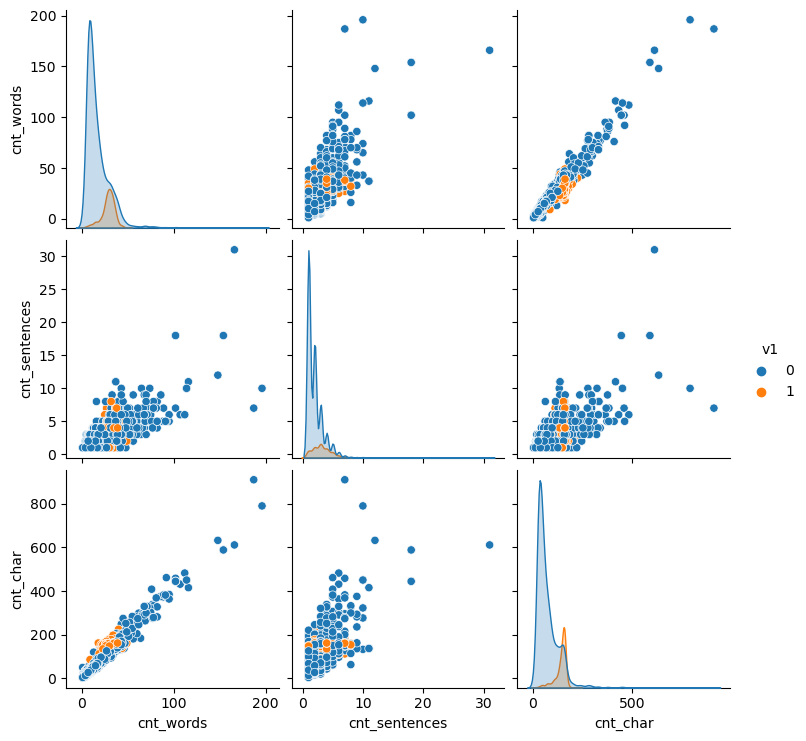

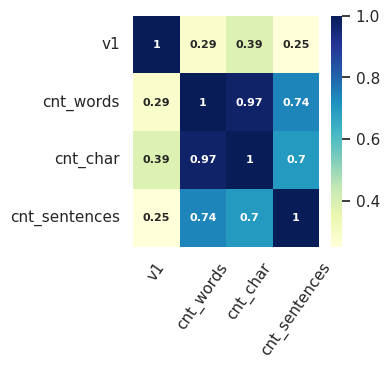

In [43]:
# Plottings

# Pairplot
sns.pairplot(df, hue='v1')
# plt.show()

# Correlation


sns.set(font_scale = 1)
plt.figure(figsize=(3,3))
cor = df[['v1', 'cnt_words', 'cnt_char', 'cnt_sentences']].corr()
sns.heatmap(cor, annot=True, cmap="YlGnBu", xticklabels=True, yticklabels=True, annot_kws={'fontsize': 8, 'fontweight': 'bold'})
plt.xticks(rotation=55)
# plt.show()




(-0.5, 799.5, 599.5, -0.5)

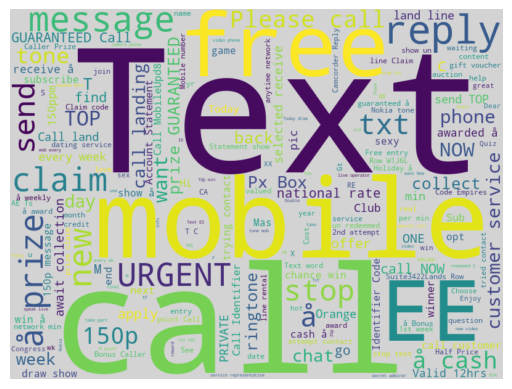

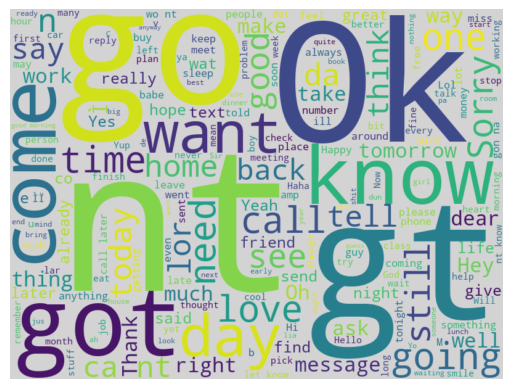

In [44]:
# WordCloud

from wordcloud import WordCloud

wc = WordCloud(background_color='lightgrey', colormap='viridis', width=800, height=600)
wc_spam = wc.generate(df[df['v1'] == 1]['v2'].str.cat(sep=" "))
# make figure to plot
plt.figure()
# plot words
plt.imshow(wc_spam, interpolation="bilinear")
# remove axes
plt.axis("off")
# show the result
# plt.show()



wc_ham = wc.generate(df[df['v1'] == 0]['v2'].str.cat(sep=" "))
# make figure to plot
plt.figure()
# plot words
plt.imshow(wc_ham, interpolation="bilinear")
# remove axes
plt.axis("off")
# show the result
# plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, '   '),
  Text(1, 0, 'I'),
  Text(2, 0, 'nt'),
  Text(3, 0, '     '),
  Text(4, 0, '    '),
  Text(5, 0, '2'),
  Text(6, 0, 'YOU'),
  Text(7, 0, 'get'),
  Text(8, 0, 'gt'),
  Text(9, 0, 'know'),
  Text(10, 0, 'go'),
  Text(11, 0, 'You'),
  Text(12, 0, 'come'),
  Text(13, 0, 'call'),
  Text(14, 0, 'like'),
  Text(15, 0, 'got'),
  Text(16, 0, 'day'),
  Text(17, 0, 'want'),
  Text(18, 0, ' '),
  Text(19, 0, 'time'),
  Text(20, 0, 'going'),
  Text(21, 0, 'Do'),
  Text(22, 0, '4'),
  Text(23, 0, 'How'),
  Text(24, 0, 'love'),
  Text(25, 0, 'lor'),
  Text(26, 0, 'A'),
  Text(27, 0, 'need'),
  Text(28, 0, 'one'),
  Text(29, 0, 'home')])

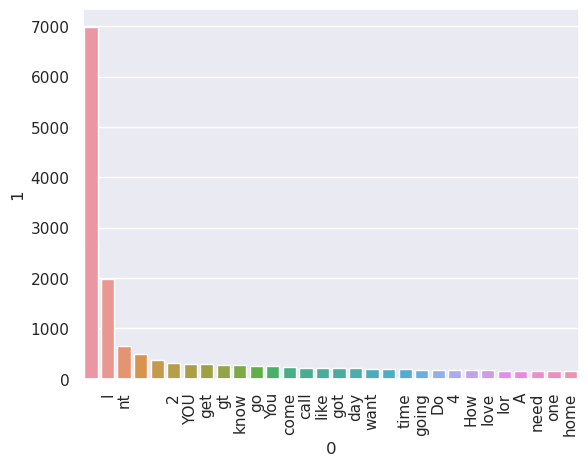

In [45]:
#Creating corpus for plotting word count

spam_corpus = []

for text in df[df['v1'] == 1]['v2'].tolist():
    for word in nlp(text):
        spam_corpus.append(word.text)




ham_corpus = []

for text in df[df['v1'] == 0]['v2'].tolist():
    for word in nlp(text):
        ham_corpus.append(word.text)


#Bar Plots


sns.barplot(x=pd.DataFrame(Counter(spam_corpus).most_common(30))[0], y=pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
# plt.show()


from collections import Counter

sns.barplot(x=pd.DataFrame(Counter(ham_corpus).most_common(30))[0], y=pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
# plt.show()

In [9]:
from sklearn.base import TransformerMixin

class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return np.array(X.todense())

In [9]:
X = df['v2']
y = df['v1']

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
np.linspace(0.01, 0.05, 5).tolist()

[0.01, 0.02, 0.03, 0.04, 0.05]

In [49]:
#Model Creation

#GaussianNB

#Imbalanced to Balanced Dataset


"""
Don't jump to sampling methods...instead use different models

"""



pipe_gnb = Pipeline([
    ('vect', TfidfVectorizer(lowercase=False, binary=True, max_df=0.25, max_features=3000, ngram_range=(2, 3), sublinear_tf=True, min_df=0.001)),
    ('to_dense', DenseTransformer()),
    # ('smote', SMOTETomek()),
    # ('trnf', PowerTransformer()),
    ('gnb', GaussianNB())
])


params_gnb = {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)],
        'vect__max_df': [0.25, 0.5, 0.75, 1.0],
        'vect__min_df': [0.001, 0.002, 0.003, 0.004, 0.005, 1],
        'vect__max_features': [3000, 4000, 5000, None],
        'vect__binary': [True, False],
        'vect__sublinear_tf': [True, False]
}



# gs_gnb = GridSearchCV(pipe_gnb, params_gnb, verbose=3, cv=5, n_jobs=-1, scoring='accuracy', error_score='raise')
# gs_gnb.fit(X_train, y_train)

# print('Best accuracy: ', gs_gnb.best_score_, end='\n')
# print('Params: ', gs_gnb.best_params_)



In [50]:
pipe_gnb.fit(X_train, y_train)

y_pred_gnb = pipe_gnb.predict(X_test)
y_pred_train_gnb = pipe_gnb.predict(X_train)

#Accuracy

test = accuracy_score(y_test, y_pred_gnb)
train = accuracy_score(y_train, y_pred_train_gnb)
matrix = confusion_matrix(y_test, y_pred_gnb)
report = classification_report(y_test, y_pred_gnb)
# print("Accuracy: ", "Test: ", test, "Train: ", train, end="\n")
# print("Confusion Matrix: ", matrix, end="\n")
# print('Classification Report: ', report, end="\n")


# Validation

kfold_validation = KFold(10)
results = cross_val_score(pipe_gnb, X_train, y_train, cv=kfold_validation, scoring='accuracy')

# print("Results KFoldCrossValidation: ", results, end='\n')
acc_gnb = np.mean(results)
# print()
# print("Accuracy KFoldCrossValidation: ", acc_gnb * 100, end='\n')

recall = recall_score(y_test, y_pred_gnb)
precision = precision_score(y_test, y_pred_gnb)
f1 = f1_score(y_test, y_pred_gnb)


In [51]:
# ROC_AUC score calculation

score = roc_auc_score(y_test, pipe_gnb.fit(X_train, y_train).predict_proba(X_test)[:, 1])
store(['GaussianNB', acc_gnb, test, train, recall, precision, f1, score])

In [52]:
# roc curve for logistic regression model with optimal threshold
from numpy import argmax
from sklearn.metrics import roc_curve

#Checking Threshold
yhat = pipe_gnb.fit(X_train, y_train).predict_proba(X_test)[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
# print('Best Threshold=%f' % (best_thresh))
# print(yhat)
# print(J)

#No need now :)

In [28]:
#Model Creation

#BernoulliNB



pipe_bnb = Pipeline([
    ('vect', TfidfVectorizer(lowercase=False, binary=True, max_df=0.3, max_features=3000, ngram_range=(1,1),  sublinear_tf=True)),
    ('bnb', BernoulliNB(binarize=0.2))
])


params_bnb = {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'vect__max_df': [0.25, 0.5, 0.75, 1.0],
        # 'vect__min_df': [0.0, 0.1, 0.2],
        'vect__max_features': [3000, 4000, 5000, None],
        'vect__binary': [True, False],
        'vect__sublinear_tf': [True, False],
        'bnb__binarize': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}



# gs_bnb = GridSearchCV(pipe_bnb, params_bnb, verbose=10, cv=5, n_jobs=-1, scoring='accuracy', error_score='raise')
# gs_bnb.fit(X_train, y_train)

# Best accuracy:  0.9743589743589742
# Params:  {'bnb__binarize': 0.2, 'cnt__binary': True, 'cnt__max_df': 0.25, 'cnt__max_features': 3000, 'cnt__ngram_range': (1, 1), 'trnf__sublinear_tf': True}


# print('Best accuracy: ', gs_bnb.best_score_, end='\n')
# print('Params: ', gs_bnb.best_params_)



In [29]:
pipe_bnb.fit(X_train, y_train)

y_pred_bnb = pipe_bnb.predict(X_test)
y_pred_train_bnb = pipe_bnb.predict(X_train)

#Accuracy

test = accuracy_score(y_test, y_pred_bnb)
train = accuracy_score(y_train, y_pred_train_bnb)
matrix = confusion_matrix(y_test, y_pred_bnb)
report = classification_report(y_test, y_pred_bnb)
print("Accuracy: ", "Test: ", test, "Train: ", train, end="\n")
print("Confusion Matrix: ", matrix, end="\n")
print('Classification Report: ', report, end="\n")


# Validation

kfold_validation = KFold(10)
results = cross_val_score(pipe_bnb, X_train, y_train, cv=kfold_validation, scoring='accuracy')

# print("Results KFoldCrossValidation: ", results, end='\n')
acc_bnb = np.mean(results)
# print()
# print("Accuracy KFoldCrossValidation: ", acc_bnb * 100, end='\n')

recall = recall_score(y_test, y_pred_bnb)
precision = precision_score(y_test, y_pred_bnb)
f1 = f1_score(y_test, y_pred_bnb)
score = roc_auc_score(y_test, pipe_bnb.fit(X_train, y_train).predict_proba(X_test)[:, 1])


store(['BernoulliNB', acc_bnb, test, train, recall, precision, f1, score])

Accuracy:  Test:  0.9766746411483254 Train:  0.9856410256410256
Confusion Matrix:  [[1445    8]
 [  31  188]]
Classification Report:                precision    recall  f1-score   support

           0       0.98      0.99      0.99      1453
           1       0.96      0.86      0.91       219

    accuracy                           0.98      1672
   macro avg       0.97      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672



In [30]:
df.shape

(1, 1)

In [31]:
  #Model Creation

#MultinomialNB



pipe_mnb = Pipeline([
    ('vect', TfidfVectorizer(lowercase=False, binary=True, max_df=0.25, max_features=3000, ngram_range=(1, 1), sublinear_tf=True, min_df=0.01)),
    ('mnb', MultinomialNB())
])


params_mnb = {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)],
        'vect__max_df': [0.25, 0.5, 0.75, 1.0],
        'vect__min_df': [0.001, 0.002, 0.003, 0.004, 0.005, 1],
        'vect__max_features': [3000, 4000, 5000, None],
        'vect__binary': [True, False],
        'vect__sublinear_tf': [True, False],
}

# # Best accuracy:  0.9697435897435897
# Params:  {'vect__binary': True, 'vect__max_df': 0.25, 'vect__max_features': 3000, 'vect__ngram_range': (1, 2), 'vect__sublinear_tf': True

# gs_mnb = GridSearchCV(pipe_mnb, params_mnb, verbose=10, cv=5, n_jobs=-1, scoring='accuracy', error_score='raise')
# gs_mnb.fit(X_train, y_train)


# print('Best accuracy: ', gs_mnb.best_score_, end='\n')
# print('Params: ', gs_mnb.best_params_)



In [32]:
pipe_mnb.fit(X_train, y_train)

y_pred_mnb = pipe_mnb.predict(X_test)
y_pred_train_mnb = pipe_mnb.predict(X_train)

#Accuracy

test = accuracy_score(y_test, y_pred_mnb)
train = accuracy_score(y_train, y_pred_train_mnb)
matrix = confusion_matrix(y_test, y_pred_mnb)
report = classification_report(y_test, y_pred_mnb)
# print("Accuracy: ", "Test: ", test, "Train: ", train, end="\n")
# print("Confusion Matrix: ", matrix, end="\n")
# print('Classification Report: ', report, end="\n")


# Validation

kfold_validation = KFold(10)
results = cross_val_score(pipe_mnb, X_train, y_train, cv=kfold_validation, scoring='accuracy')

# print("Results KFoldCrossValidation: ", results, end='\n')
acc_mnb = np.mean(results)
# print()
# print("Accuracy KFoldCrossValidation: ", acc_mnb * 100, end='\n')

recall = recall_score(y_test, y_pred_mnb)
precision = precision_score(y_test, y_pred_mnb)
f1 = f1_score(y_test, y_pred_mnb)
score = roc_auc_score(y_test, pipe_mnb.fit(X_train, y_train).predict_proba(X_test)[:, 1])


store(['MultinomialNB', acc_mnb, test, train, recall, precision, f1, score])

In [33]:
  #Model Creation

#LogisticRegression



pipe_lr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=False, binary=False, max_features=3000, min_df=0.001, ngram_range=(1, 3), sublinear_tf=True)),
    ('lr', LogisticRegression(C=10, penalty='l2',solver='liblinear'))
])
# Best accuracy:  0.978974358974359
# Params:  {'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'vect__binary': False, 'vect__max_df': 0.25, 'vect__max_features': 3000, 'vect__min_df': 0.001, 'vect__ngram_range': (1, 3), 'vect__sublinear_tf': True}

params_lr = {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)],
        'vect__max_df': [0.25, 0.5, 0.75, 1.0],
        'vect__min_df': [0.001, 0.002, 0.003, 1],
        'vect__max_features': [3000, 4000, None],
        'vect__binary': [True, False],
        'vect__sublinear_tf': [True, False],
        'lr__penalty': ['l1', 'l2'],
        'lr__solver': ['liblinear', 'saga'],
        'lr__C': [1.0, 0.1, 0.01, 0.001, 10]
}


# gs_lr = GridSearchCV(pipe_lr, params_lr, verbose=10, cv=5, n_jobs=-1, scoring='accuracy', error_score='raise')
# gs_lr.fit(X_train, y_train)


# print('Best accuracy: ', gs_lr.best_score_, end='\n')
# print('Params: ', gs_lr.best_params_)



In [34]:
pipe_lr.fit(X_train, y_train)

y_pred_lr = pipe_lr.predict(X_test)
y_pred_train_lr = pipe_lr.predict(X_train)

#Accuracy

test = accuracy_score(y_test, y_pred_lr)
train = accuracy_score(y_train, y_pred_train_lr)
matrix = confusion_matrix(y_test, y_pred_lr)
report = classification_report(y_test, y_pred_lr)
# print("Accuracy: ", "Test: ", test, "Train: ", train, end="\n")
# print("Confusion Matrix: ", matrix, end="\n")
# print('Classification Report: ', report, end="\n")


# Validation

kfold_validation = KFold(10)
results = cross_val_score(pipe_lr, X_train, y_train, cv=kfold_validation, scoring='accuracy')

# print("Results KFoldCrossValidation: ", results, end='\n')
acc_lr = np.mean(results)
# print()
# print("Accuracy KFoldCrossValidation: ", acc_lr * 100, end='\n')

recall = recall_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
score = roc_auc_score(y_test, pipe_lr.fit(X_train, y_train).predict_proba(X_test)[:, 1])


store(['LogisticRegression', acc_lr, test, train, recall, precision, f1, score])

In [35]:
#Model Creation

#KNN

pipe_knn = Pipeline([
    ('vect', TfidfVectorizer(lowercase=False, binary=False, max_df=0.25, max_features=None, min_df=1, ngram_range=(1, 2),  sublinear_tf=True)),
    ('knn', KNeighborsClassifier(n_neighbors=9, weights='distance',n_jobs=-1))
])

params_knn = {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)],
        'vect__max_df': [0.25, 0.5, 0.75, 1.0],
        'vect__min_df': [0.001, 0.002, 0.003, 1],
        'vect__max_features': [3000, 4000, None],
        'vect__binary': [True, False],
        'vect__sublinear_tf': [True, False],
        'knn__n_neighbors': [3, 5, 7, 9],
        'knn__weights': ['uniform', 'distance']
}


# gs_knn = GridSearchCV(pipe_knn, params_knn, verbose=10, cv=5, n_jobs=-1, scoring='accuracy', error_score='raise')
# gs_knn.fit(X_train, y_train)


# print('Best accuracy: ', gs_knn.best_score_, end='\n')
# print('Params: ', gs_knn.best_params_)



In [36]:
pipe_knn.fit(X_train, y_train)

y_pred_knn = pipe_knn.predict(X_test)
y_pred_train_knn = pipe_knn.predict(X_train)

#Accuracy

test = accuracy_score(y_test, y_pred_knn)
train = accuracy_score(y_train, y_pred_train_knn)
matrix = confusion_matrix(y_test, y_pred_knn)
report = classification_report(y_test, y_pred_knn)
# print("Accuracy: ", "Test: ", test, "Train: ", train, end="\n")
# print("Confusion Matrix: ", matrix, end="\n")
# print('Classification Report: ', report, end="\n")


# Validation

kfold_validation = KFold(10)
results = cross_val_score(pipe_knn, X_train, y_train, cv=kfold_validation, scoring='accuracy')

# print("Results KFoldCrossValidation: ", results, end='\n')
acc_knn = np.mean(results)
# print()
# print("Accuracy KFoldCrossValidation: ", acc_knn * 100, end='\n')

recall = recall_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)
score = roc_auc_score(y_test, pipe_knn.fit(X_train, y_train).predict_proba(X_test)[:, 1])
# data_accuracy = data_accuracy[:-1]

store(['KNN', acc_knn, test, train, recall, precision, f1, score])

In [37]:
  #Model Creation

#SVC

pipe_svc = Pipeline([
    ('vect', TfidfVectorizer(lowercase=False, sublinear_tf=True, ngram_range=(1, 2), min_df=1, max_features=None, max_df=0.25, binary=False)),
    ('svc', SVC(probability=True, kernel='linear', gamma=0.1, degree=3, class_weight='balanced', C=10))
])


params_svc = {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'vect__max_df': [0.25, 0.5, 1.0],
        'vect__min_df': [0.001, 0.002, 1],
        'vect__max_features': [3000,  None],
        'vect__binary': [True, False],
        'svc__C': [1.0, 0.1, 0.01, 10 ,0.001],
        'svc__kernel': ['poly', 'sigmoid', 'linear'],
        'svc__degree': [2, 3, 4],
        'svc__class_weight': [None, 'balanced'],
        'svc__gamma':[1, 10, 0.1, 100]
}


# gs_svc = GridSearchCV(pipe_svc, params_svc, verbose=10, cv=5, n_jobs=-1, scoring='accuracy', error_score='raise')
# gs_svc.fit(X_train, y_train)


# print('Best accuracy: ', gs_svc.best_score_, end='\n')
# print('Params: ', gs_svc.best_params_)



In [38]:
pipe_svc.fit(X_train, y_train)

y_pred_svc = pipe_svc.predict(X_test)
y_pred_train_svc = pipe_svc.predict(X_train)

#Accuracy

test = accuracy_score(y_test, y_pred_svc)
train = accuracy_score(y_train, y_pred_train_svc)
matrix = confusion_matrix(y_test, y_pred_svc)
report = classification_report(y_test, y_pred_svc)
# print("Accuracy: ", "Test: ", test, "Train: ", train, end="\n")
# print("Confusion Matrix: ", matrix, end="\n")
# print('Classification Report: ', report, end="\n")


# Validation

kfold_validation = KFold(10)
results = cross_val_score(pipe_svc, X_train, y_train, cv=kfold_validation, scoring='accuracy')

# print("Results KFoldCrossValidation: ", results, end='\n')
acc_svc = np.mean(results)
# print()
# print("Accuracy KFoldCrossValidation: ", acc_svc * 100, end='\n')

recall = recall_score(y_test, y_pred_svc)
precision = precision_score(y_test, y_pred_svc)
f1 = f1_score(y_test, y_pred_svc)
score = roc_auc_score(y_test, pipe_svc.fit(X_train, y_train).predict_proba(X_test)[:, 1])


store(['SVC', acc_svc, test, train, recall, precision, f1, score])

In [39]:

#Model Creation

#DecisionTrees

pipe_dt = Pipeline([
    ('vect', TfidfVectorizer(lowercase=False, sublinear_tf=True, ngram_range=(1, 2), min_df=0.01, max_features=3000, max_df=0.75, binary=False)),
    ('dt', DecisionTreeClassifier(splitter='best', min_samples_split=0.75, min_samples_leaf=15, max_depth=None, criterion='gini', class_weight=None))
])


params_dt = {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'vect__max_df': [0.25, 0.5, 0.75],
        'vect__min_df': [0.001, 0.002, 1],
        'vect__max_features': [3000, None],
        'vect__binary': [True, False],
        'vect__sublinear_tf': [True],
        "dt__criterion": ["gini"],
        "dt__splitter": ["best"],
        "dt__max_depth": [None, 5, 10, 15, 17],
        'dt__class_weight': [None, 'balanced'],
        # "dt__ccp_alpha": ccp_alpha_new,
        "dt__min_samples_split": [2, 4, 8, 16],
        "dt__min_samples_leaf": [15, 20, 0.33, 0.25],
}


# gs_dt = GridSearchCV(pipe_dt, params_dt, verbose=10, cv=5, n_jobs=-1, scoring='accuracy', error_score='raise')
# gs_dt.fit(X_train, y_train)


# print('Best accuracy: ', gs_dt.best_score_, end='\n')
# print('Params: ', gs_dt.best_params_)

In [40]:
pipe_dt.fit(X_train, y_train)

y_pred_dt = pipe_dt.predict(X_test)
y_pred_train_dt = pipe_dt.predict(X_train)

#Accuracy

test = accuracy_score(y_test, y_pred_dt)
train = accuracy_score(y_train, y_pred_train_dt)
matrix = confusion_matrix(y_test, y_pred_dt)
report = classification_report(y_test, y_pred_dt)
# print("Accuracy: ", "Test: ", test, "Train: ", train, end="\n")
# print("Confusion Matrix: ", matrix, end="\n")
# print('Classification Report: ', report, end="\n")


# Validation

kfold_validation = KFold(10)
results = cross_val_score(pipe_dt, X_train, y_train, cv=kfold_validation, scoring='accuracy')

# print("Results KFoldCrossValidation: ", results, end='\n')
acc_dt = np.mean(results)
# print()
# print("Accuracy KFoldCrossValidation: ", acc_dt * 100, end='\n')

recall = recall_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)
score = roc_auc_score(y_test, pipe_dt.fit(X_train, y_train).predict_proba(X_test)[:, 1])
# data_accuracy = data_accuracy[:-1]
store(['DecisionTreesC', acc_dt, test, train, recall, precision, f1, score])

In [41]:

#Model Creation

#RandomForestClassifier

pipe_rf = Pipeline([
    ('vect', TfidfVectorizer(lowercase=False, sublinear_tf=True, ngram_range=(1, 3), min_df=1, max_features=None, max_df=0.75, binary=False)),
    ('rf', RandomForestClassifier(n_jobs=-1, n_estimators=200, min_samples_split=0.25, min_samples_leaf=10, max_depth=15, criterion='gini', class_weight='balanced_subsample', bootstrap=False))
])

# Best accuracy:  0.9705128205128206
# Params:  {'vect__sublinear_tf': True, 'vect__ngram_range': (1, 3), 'vect__min_df': 1, '
#           vect__max_features': None, 'vect__max_df': 0.75, 'vect__binary': False,
#           'rf__n_estimators': 200, 'rf__min_samples_split': 0.25, 'rf__min_samples_leaf': 10,
#           'rf__max_depth': 15, 'rf__criterion': 'gini', 'rf__class_weight': 'balanced_subsample', 'rf__bootstrap': False}


params_rf = {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (3, 3)],
        'vect__max_df': [0.25, 0.5, 0.75, 1.0],
        'vect__min_df': [0.001, 0.002, 0.003, 1],
        'vect__max_features': [3000, 4000, None],
        'vect__binary': [True, False],
        'vect__sublinear_tf': [True],
        "rf__criterion": ["gini", "entropy"],
        "rf__n_estimators": [100, 200, 300],
        "rf__max_depth": [None, 5, 10, 13, 15, 17],
        "rf__bootstrap": [True, False],
        "rf__min_samples_split": [2, 0.33, 0.50, 0.25],
        "rf__min_samples_leaf": [10, 15, 20],
        "rf__class_weight": ['balanced', 'balanced_subsample', None],
}

# rf_gs = RandomizedSearchCV(pipe_rf, params_rf, n_iter=200, verbose=10, cv=10, n_jobs=-1, scoring='accuracy', error_score='raise')
# rf_gs.fit(X_train, y_train)


# print('Best accuracy: ', rf_gs.best_score_, end='\n')
# print('Params: ', rf_gs.best_params_)

In [42]:
pipe_rf.fit(X_train, y_train)

y_pred_rf = pipe_rf.predict(X_test)
pred_train_rf = pipe_rf.predict(X_train)

#Accuracy

test = accuracy_score(y_test, y_pred_rf)
train = accuracy_score(y_train, pred_train_rf)
matrix = confusion_matrix(y_test, y_pred_rf)
report = classification_report(y_test, y_pred_rf)
# print("Accuracy: ", "Test: ", test, "Train: ", train, end="\n")
# print("Confusion Matrix: ", matrix, end="\n")
# print('Classification Report: ', report, end="\n")


# Validation

kfold_validation = KFold(10)
results = cross_val_score(pipe_rf, X_train, y_train, cv=kfold_validation, scoring='accuracy')

# print("Results KFoldCrossValidation: ", results, end='\n')
acc_rf = np.mean(results)
# print()
# print("Accuracy KFoldCrossValidation: ", acc_dt * 100, end='\n')

recall = recall_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
score = roc_auc_score(y_test, pipe_rf.fit(X_train, y_train).predict_proba(X_test)[:, 1])
store(['RandomForestClassifier', acc_rf, test, train, recall, precision, f1, score])

In [43]:

#Model Creation

#GradientBoostingClassifier

pipe_gb = Pipeline([
    ('vect', TfidfVectorizer(lowercase=False, sublinear_tf=True, ngram_range=(1, 3), min_df=0.001, max_features=3000, max_df=0.25, binary=False)),
    ('gb', GradientBoostingClassifier(n_estimators=300, min_samples_split=0.33, min_samples_leaf=20, min_impurity_decrease=0.01, max_depth=3, learning_rate=1, init=RandomForestClassifier(), criterion='friedman_mse'))
])

# # Best accuracy:  0.9805128205128206
# Params:  {'vect__sublinear_tf': True, 'vect__ngram_range': (1, 3), 'vect__min_df': 0.001,
#           'vect__max_features': 3000, 'vect__max_df': 0.25, 'vect__binary': False,
#           'gb__n_estimators': 300, 'gb__min_samples_split': 0.33, 'gb__min_samples_leaf': 20,
#           'gb__min_impurity_decrease': 0.01, 'gb__max_depth': 3, 'gb__learning_rate': 1,
#           'gb__init': RandomForestClassifier(), 'gb__criterion': 'friedman_mse'}

params_gb = {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'vect__max_df': [0.25, 0.5, 0.75],
        'vect__min_df': [0.001, 0.002, 1],
        'vect__max_features': [3000, None],
        'vect__binary': [False],
        'vect__sublinear_tf': [True],
        'gb__init': [RandomForestClassifier()],
        'gb__learning_rate': [1, 0.1, 0.01],
        'gb__n_estimators': [200, 300],
        'gb__criterion': ['friedman_mse', 'squared_error'],
        "gb__min_samples_split": [0.33, 0.50, 0.25],
        "gb__max_depth": [None, 3, 6, 9],
        "gb__min_samples_leaf": [15, 20],
        'gb__min_impurity_decrease': [0.0, 0.1, 0.01]
}

# gb_gs = RandomizedSearchCV(pipe_gb, params_gb, n_iter=200, verbose=10, cv=10, n_jobs=-1, scoring='accuracy', error_score='raise')
# gb_gs.fit(X_train, y_train)


# print('Best accuracy: ', gb_gs.best_score_, end='\n')
# print('Params: ', gb_gs.best_params_)

In [44]:
pipe_gb.fit(X_train, y_train)

y_pred_gb = pipe_gb.predict(X_test)
pred_train_gb = pipe_gb.predict(X_train)

#Accuracy

test = accuracy_score(y_test, y_pred_gb)
train = accuracy_score(y_train, pred_train_gb)
matrix = confusion_matrix(y_test, y_pred_gb)
report = classification_report(y_test, y_pred_gb)
# print("Accuracy: ", "Test: ", test, "Train: ", train, end="\n")
# print("Confusion Matrix: ", matrix, end="\n")
# print('Classification Report: ', report, end="\n")


# Validation

kfold_validation = KFold(10)
results = cross_val_score(pipe_gb, X_train, y_train, cv=kfold_validation, scoring='accuracy')

# print("Results KFoldCrossValidation: ", results, end='\n')
acc_gb = np.mean(results)
# print()
# print("Accuracy KFoldCrossValidation: ", acc_gb * 100, end='\n')

recall = recall_score(y_test, y_pred_gb)
precision = precision_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)
score = roc_auc_score(y_test, pipe_gb.fit(X_train, y_train).predict_proba(X_test)[:, 1])
# data_accuracy=data_accuracy[:-1]
store(['GradientBoostingClassifier', acc_gb, test, train, recall, precision, f1, score])

In [45]:

#Model Creation

#AdaBoostClassifier

pipe_ab = Pipeline([
    ('vect', TfidfVectorizer(lowercase=False, sublinear_tf=True, ngram_range=(1, 3), min_df=0.001, max_features=3000, max_df=0.5, binary=False)),
    ('ab', AdaBoostClassifier(estimator=RandomForestClassifier(), n_estimators=100, learning_rate=1))
])


params_ab = {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)],
        'vect__max_df': [0.25, 0.5, 0.75, 1.0],
        'vect__min_df': [0.001, 0.002, 0.003, 1],
        'vect__max_features': [3000, None],
        'vect__binary': [False],
        'vect__sublinear_tf': [True],
        'ab__learning_rate': [1, 10, 0.1, 0.01],
        'ab__n_estimators': [100, 150, 200],
}

# ab_gs = GridSearchCV(pipe_ab, params_ab, verbose=10, cv=5, n_jobs=-1, scoring='accuracy', error_score='raise')
# ab_gs.fit(X_train, y_train)

# print('Best accuracy: ', ab_gs.best_score_, end='\n')
# print('Params: ', ab_gs.best_params_)

In [46]:
pipe_ab.fit(X_train, y_train)

y_pred_ab = pipe_ab.predict(X_test)
pred_train_ab = pipe_ab.predict(X_train)

#Accuracy

test = accuracy_score(y_test, y_pred_ab)
train = accuracy_score(y_train, pred_train_ab)
matrix = confusion_matrix(y_test, y_pred_ab)
report = classification_report(y_test, y_pred_ab)
# print("Accuracy: ", "Test: ", test, "Train: ", train, end="\n")
# print("Confusion Matrix: ", matrix, end="\n")
# print('Classification Report: ', report, end="\n")


# Validation

kfold_validation = KFold(10)
results = cross_val_score(pipe_ab, X_train, y_train, cv=kfold_validation, scoring='accuracy')

# print("Results KFoldCrossValidation: ", results, end='\n')
acc_ab = np.mean(results)
# print()
# print("Accuracy KFoldCrossValidation: ", acc_ab * 100, end='\n')

recall = recall_score(y_test, y_pred_ab)
precision = precision_score(y_test, y_pred_ab)
f1 = f1_score(y_test, y_pred_ab)
score = roc_auc_score(y_test, pipe_ab.fit(X_train, y_train).predict_proba(X_test)[:, 1])
# data_accuracy=data_accuracy[:-1]
store(['AdaBoostClassifier', acc_ab, test, train, recall, precision, f1, score])

In [47]:

#Model Creation

#BaggingClassifier

pipe_bg = Pipeline([
    ('vect', TfidfVectorizer(lowercase=False, sublinear_tf=True, ngram_range=(1, 1), min_df=0.001, max_features=4000,max_df=0.25, binary=True)),
    ('bg', BaggingClassifier(n_jobs=-1, estimator=RandomForestClassifier(), n_estimators=50, bootstrap_features=True, bootstrap=False))
])

params_bg = {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (3, 3)],
        'vect__max_df': [0.25, 0.5, 0.75, 1.0],
        'vect__min_df': [0.001, 0.002, 0.003, 1],
        'vect__max_features': [3000, 4000, None],
        'vect__binary': [True, False],
        'vect__sublinear_tf': [True],
        'bg__bootstrap': [True, False],
        'bg__bootstrap_features': [True, False],
#         'bg__oob_score': [True, False],
        'bg__n_estimators': [50, 100, 150, 200]
}

# bg_gs = RandomizedSearchCV(pipe_bg, params_bg, n_iter=200, verbose=10, cv=10, n_jobs=-1, scoring='accuracy', error_score='raise')
# bg_gs.fit(X_train, y_train)


# print('Best accuracy: ', bg_gs.best_score_, end='\n')
# print('Params: ', bg_gs.best_params_)

In [ ]:
pipe_bg.fit(X_train, y_train)

y_pred_bg = pipe_bg.predict(X_test)
pred_train_bg = pipe_bg.predict(X_train)

#Accuracy

test = accuracy_score(y_test, y_pred_bg)
train = accuracy_score(y_train, pred_train_bg)
matrix = confusion_matrix(y_test, y_pred_bg)
report = classification_report(y_test, y_pred_bg)
# print("Accuracy: ", "Test: ", test, "Train: ", train, end="\n")
# print("Confusion Matrix: ", matrix, end="\n")
# print('Classification Report: ', report, end="\n")


# Validation

kfold_validation = KFold(10)
results = cross_val_score(pipe_bg, X_train, y_train, cv=kfold_validation, scoring='accuracy')

# print("Results KFoldCrossValidation: ", results, end='\n')
acc_bg = np.mean(results)
# print()
# print("Accuracy KFoldCrossValidation: ", acc_bg * 100, end='\n')

recall = recall_score(y_test, y_pred_bg)
precision = precision_score(y_test, y_pred_bg)
f1 = f1_score(y_test, y_pred_bg)
score = roc_auc_score(y_test, pipe_bg.fit(X_train, y_train).predict_proba(X_test)[:, 1])
# data_accuracy=data_accuracy[:-1]
store(['BaggingClassifier', acc_bg, test, train, recall, precision, f1, score])

In [10]:

#Model Creation

#VotingClassifier

# algos = [('bg', BaggingClassifier(estimator=RandomForestClassifier(), n_estimators=50, bootstrap_features=True, bootstrap=False)), ('rf', RandomForestClassifier(n_estimators=200, min_samples_split=0.25, min_samples_leaf=10, max_depth=15, criterion='gini', class_weight='balanced_subsample', bootstrap=False)), ('lr', LogisticRegression(C=10, penalty='l2',solver='liblinear'))]


pipe_vc = Pipeline([
    ('vect', TfidfVectorizer(lowercase=False, binary=True, max_df=0.75, max_features=None, min_df=0.001, ngram_range=(1, 1), sublinear_tf=True)),
    # ('to_dense', DenseTransformer()),
    ('vc', VotingClassifier(estimators=[('bg', BaggingClassifier(estimator=RandomForestClassifier(), n_estimators=50, bootstrap_features=True, bootstrap=False)),  
                                        ('bnb', BernoulliNB(binarize=0.2)),
                                         ('lr', LogisticRegression(C=10, penalty='l2',solver='liblinear'))], voting='soft'))
])

params_vc = {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)],
        'vect__max_df': [0.25, 0.5, 0.75, 1.0],
        'vect__min_df': [0.001, 0.002, 0.003, 1],
        'vect__max_features': [3000, 4000, None],
        'vect__binary': [True, False],
        'vect__sublinear_tf': [True],
        'vc__voting': ['soft', 'hard']
}


# Best accuracy:  0.9764102564102565
# Params:  {'vc__voting': 'soft', 'vect__binary': True, 'vect__max_df': 0.75, 'vect__max_features': None, 'vect__min_df': 0.001, 'vect__ngram_range': (1, 1), 'vect__sublinear_tf': True}

# vc_gs = RandomizedSearchCV(pipe_vc, params_vc, n_iter=200, verbose=10, cv=10, n_jobs=-1, scoring='accuracy', error_score='raise')
# vc_gs.fit(X_train, y_train)


# print('Best accuracy: ', vc_gs.best_score_, end='\n')
# print('Params: ', vc_gs.best_params_)

In [11]:
pipe_vc.fit(X_train, y_train)

y_pred_vc = pipe_vc.predict(X_test)
pred_train_vc = pipe_vc.predict(X_train)

#Accuracy

test = accuracy_score(y_test, y_pred_vc)
train = accuracy_score(y_train, pred_train_vc)
matrix = confusion_matrix(y_test, y_pred_vc)
report = classification_report(y_test, y_pred_vc)
# print("Accuracy: ", "Test: ", test, "Train: ", train, end="\n")
# print("Confusion Matrix: ", matrix, end="\n")
# print('Classification Report: ', report, end="\n")


# Validation

kfold_validation = KFold(10)
results = cross_val_score(pipe_vc, X_train, y_train, cv=kfold_validation, scoring='accuracy')

# print("Results KFoldCrossValidation: ", results, end='\n')
acc_vc = np.mean(results)
# print()
# print("Accuracy KFoldCrossValidation: ", acc_vc * 100, end='\n')

recall = recall_score(y_test, y_pred_vc)
precision = precision_score(y_test, y_pred_vc)
f1 = f1_score(y_test, y_pred_vc)
score = roc_auc_score(y_test, pipe_vc.fit(X_train, y_train).predict_proba(X_test)[:, 1])
store(['VotingClassifier', acc_vc, test, train, recall, precision, f1, score])

In [ ]:
data_accuracy.to_csv('metrics.csv')

In [49]:
data_accuracy.columns

Index(['Algo', 'Accuracy(KFold)', 'Test', 'Train', 'Recall', 'Precision', 'F1', 'ROC_AUC_SCORE'], dtype='object')

In [50]:
data_accuracy.sort_values(['Precision', 'Accuracy(KFold)'], ascending=[False, False])

,Algo,Accuracy(KFold),Test,Train,Recall,Precision,F1,ROC_AUC_SCORE
4,KNN,0.943846,0.945574,1.000000,0.584475,1.000000,0.737752,0.961434
10,VotingClassifier,0.980769,0.976675,0.997436,0.826484,0.994505,0.902743,0.986399
0,GaussianNB,0.945385,0.951555,0.956667,0.634703,0.992857,0.774373,0.817007
11,BaggingClassifier,0.977949,0.976077,0.999744,0.826484,0.989071,0.900498,0.984510
9,BaggingClassifier,0.976923,0.973684,0.999744,0.808219,0.988827,0.889447,0.985041
3,LogisticRegression,0.979487,0.974282,0.997436,0.821918,0.978261,0.893300,0.986487
8,GradientBoostingClassifier,0.977179,0.974880,0.999231,0.831050,0.973262,0.896552,0.986840
5,SVC,0.984359,0.983852,1.000000,0.913242,0.961538,0.936768,0.989626
1,BernoulliNB,0.975128,0.976077,0.985128,0.853881,0.958974,0.903382,0.977823
7,RandomForestClassifier,0.969231,0.965909,0.978974,0.776256,0.955056,0.856423,0.967587


In [12]:
import pickle
pickle.dump(pipe_vc, open('model_pipeline_vc.pkl', 'wb'))

In [14]:
!pip install pipreqs

In [15]:
!pwd


/home/mist/Desktop/ML/Project/SMS Spam Collection Dataset


In [22]:
!pipreqs .

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in ./requirements.txt
